# Cross validation analysis of final evaluation results between different techniques

Tong Shu Li<br>
Created on: 2015-10-08<br>
Last updated: 2015-10-20

The team at UTexas was kind enough to send their final predictions for the CID task. We will compare their results to the crowd's and see where their outputs differed.

In [1]:
from collections import defaultdict
from itertools import permutations
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

In [2]:
RAND_KEY = np.random.RandomState(20151007)

In [3]:
%matplotlib inline

In [4]:
matplotlib.rcParams.update({'font.size': 12})

In [5]:
sys.path.append("..")

In [6]:
from src.lingpipe.file_util import read_file
from src.lingpipe.file_util import save_file

from src.data_model import Ontology_ID
from src.data_model import Relation
from src.data_model import parse_input
from src.data_model import parse_file
from src.data_model import Annotation

from src.eval_perf import performance
from src.parse_mesh import load_mesh
from src.get_mesh_terms import Article

In [7]:
TRIPLE = ["pmid", "chemical_id", "disease_id"]

---

## Global functions

In [8]:
def make_df(triples):
    """Converts a given set of (pmid, chemical_id, disease_id)
    triples into a three column dataframe."""
    return pd.DataFrame(list(triples), columns = TRIPLE)

In [9]:
def get_triples(dataframe):
    return set(dataframe[TRIPLE].apply(
                lambda row: (int(row["pmid"]), row["chemical_id"], row["disease_id"]), axis = 1))

In [10]:
def format_set(v):
    return "\n".join(map(str, v))

def print_to_file(fname, dataset):
    with open(fname, "w") as fout:
        fout.write(dataset)

### Read the gold standard and various solutions

In [11]:
def read_output(fname):
    """Read only the CID relations from a Pubtator-formatted
    text file.
    """
    temp = defaultdict(list)
    for line in read_file(fname):
        vals = line.split("\t")
        
        if len(vals) > 1 and vals[1] == "CID":
            temp["pmid"].append(int(vals[0]))
            temp["chemical_id"].append(Ontology_ID(vals[2]).flat_repr)
            temp["disease_id"].append(Ontology_ID(vals[3]).flat_repr)
            
            if len(vals) > 4:
                temp["threshold"].append(float(vals[4]))

    return pd.DataFrame(temp)

In [12]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development", "test"]
    assert file_format in ["list", "dict"]
    
    fname = "parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    save_loc = os.path.abspath(os.path.join("..", "data", "gold_standard", fname))
    
    fname = "CDR_{0}Set.txt".format(dataset.capitalize())
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard"))
    
    return parse_file(save_loc, loc = loc, fname = fname,
        is_gold = True, return_format = file_format, fix_acronyms = False)

In [13]:
def has_concept(paper, concept_id):
    concepts = set()
    for annot in paper.annotations:
        concepts |= set([iden.flat_repr for iden in annot.uid if iden.uid_type == "MESH"])
    
    return concept_id in concepts

In [14]:
def check_exists(df, reference):
    for col in ["chemical", "disease"]:
        df.loc[:, "{}_exists".format(col[:4])] = df[TRIPLE].apply(
            lambda row: has_concept(reference[int(row["pmid"])], row["{}_id".format(col)]), axis = 1)
        
    return df

### Read the PMID mappings

In [15]:
paper_mapping = save_file("testset_mapping.pickle")

### Read the gold standard

In [16]:
eval_gold = read_gold_standard("test", file_format = "dict")

In [17]:
fname = os.path.abspath(os.path.join("..", "data", "gold_standard", "CDR_TestSet.txt"))
gold_std = read_output(fname)

### Grab the official MeSH terms for the testset and save to pickle

In [18]:
def grab_mesh(papers):
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard", "testset_mesh_terms.pickle"))

    res = save_file(loc)
    if res is not None:
        return res
    
    res = dict()
    for pmid in papers:
        res[pmid] = Article(pmid)
        
    save_file(loc, res)
    return res

In [19]:
mesh_terms = grab_mesh(set(eval_gold.keys()))

### Read UTexas's results

In [20]:
fname = os.path.abspath(os.path.join("..", "data", "utexas", "CDR_TestSet.BiC.V.CID.Run3.txt"))
ut_res = read_output(fname)

ut_res = check_exists(ut_res, eval_gold)

# fully parsed results
save_loc = os.path.abspath(os.path.join("..", "data", "utexas", "texas_full_testset.pickle"))
loc = os.path.abspath(os.path.join("..", "data", "utexas"))
ut_full = parse_file(save_loc, loc = loc, fname = "CDR_TestSet.BiC.V.CID.Run3.txt",
    is_gold = True, return_format = "dict", fix_acronyms = False)

### Read the crowd's results

In [21]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "crowd_testset.pickle"))
crowd_full = save_file(loc)
crowd_res = save_file("testset_final_res.pickle")

### Read BeFree's results

In [22]:
fname = os.path.abspath(os.path.join("..", "data", "befree", "final_eval", "befree_testset_results.txt"))
befree_res = read_output(fname)

befree_res.loc[:, "pmid"] = befree_res["pmid"].map(lambda val: paper_mapping[val])
befree_res["threshold"] = 1

befree_res = check_exists(befree_res, eval_gold)

#----------------------------------

def get_befree():
    loc = os.path.join("..", "data", "befree", "final_eval")

    save_loc = os.path.abspath(os.path.join(loc, "befree_testset_full.pickle"))
    res = save_file(save_loc)
    if res is not None:
        return res

    befree_full = parse_input(os.path.abspath(loc), "befree_testset_results.txt",
                         is_gold = True, return_format = "dict", fix_acronyms = False)

    temp = dict()
    for pmid, paper in befree_full.items():
        paper.pmid = paper_mapping[pmid]
        temp[paper_mapping[pmid]] = paper

    save_file(save_loc, temp)
    return temp
    
befree_full = get_befree()

In [23]:
gold_std.head()

,chemical_id,disease_id,pmid
0,MESH:D015738,MESH:D003693,8701013
1,MESH:D007213,MESH:D007022,439781
2,MESH:D016572,MESH:D057049,22836123
3,MESH:D000305,MESH:D012595,22836123
4,MESH:D016559,MESH:D012595,22836123


In [24]:
ut_res.head()

,chemical_id,disease_id,pmid,threshold,chem_exists,dise_exists
0,MESH:D015738,MESH:D003693,8701013,0.75,True,True
1,MESH:D015738,MESH:D014456,8701013,0.65,True,True
2,MESH:D007213,MESH:D007022,439781,0.75,True,True
3,MESH:D016572,MESH:D057049,22836123,0.75,True,True
4,MESH:D016559,MESH:D057049,22836123,0.65,True,True


In [25]:
crowd_res.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
0,MESH:D006632,MESH:D003693,0.198438,1,8701013,abstract_task
0,MESH:D006632,MESH:D014456,0.000000,0,8701013,sentence_task
1,MESH:D015738,MESH:D003693,1.000000,5,8701013,sentence_task
2,MESH:D015738,MESH:D014456,0.000000,0,8701013,sentence_task
1,MESH:D000809,MESH:D007022,0.000000,0,439781,abstract_task


In [26]:
befree_res.head()

,chemical_id,disease_id,pmid,threshold,chem_exists,dise_exists
0,MESH:D015738,MESH:D003693,8701013,1,True,True
1,MESH:D007213,MESH:D007022,439781,1,True,True
2,MESH:D016559,MESH:D045743,22836123,1,True,False
3,MESH:D008694,MESH:D011618,23433219,1,True,False
4,MESH:D007980,MESH:D004409,23535177,1,True,True


---

## Analysis functions

In [27]:
def individual_perf(triples):
    df = make_df(triples)

    res = defaultdict(list)
    for pmid, group in gold_std.groupby("pmid"):
        gold_sub = get_triples(group)
        
        predict_sub = get_triples(df.query("pmid == {}".format(pmid)))
        
        precision, recall, f1 = performance(gold_sub, predict_sub)
        
        res["pmid"].append(pmid)
        res["precision"].append(precision)
        res["recall"].append(recall)
        res["F_score"].append(f1)
        
    return pd.DataFrame(res)

## Overall performance against the gold standard

Using the official evaluation of the CID relation performance, how did each solution do?

In [28]:
def official_F_score(score_column, gold_rel_set, dataframe):
    EPSILON = 0.0000001
    
    res = defaultdict(list)
    for threshold in dataframe[score_column].unique():
        sub = dataframe.query("{0} > {1} or -{2} <= {0} - {1} <= {2}".format(score_column, threshold, EPSILON))
        
        # grab the relation ids we guessed
        predict = get_triples(sub)
        
        precision, recall, f1 = performance(gold_rel_set, predict)
        
        res["recall"].append(recall)
        res["precision"].append(precision)
        res["threshold"].append(threshold)
        res["F_score"].append(f1)
        
    return pd.DataFrame(res).sort("threshold")

### Get the gold standard triples

In [29]:
gold_triples = get_triples(gold_std)

### University of Texas performance

In [30]:
official_F_score("threshold", gold_triples, ut_res)

,F_score,precision,recall,threshold
2,0.570252,0.556747,0.584428,0.30
1,0.585269,0.618600,0.555347,0.65
0,0.520915,0.642366,0.438086,0.75


These results match exactly the published results. Note that the system would have done even better if it set its threshold to the middle value of 0.65 instead of the lowest value of 0.30.

### Crowd performance

In [31]:
official_F_score("num_votes", gold_triples, crowd_res)

,F_score,precision,recall,threshold
1,0.267624,0.162805,0.751407,0
0,0.356317,0.236486,0.722326,1
3,0.444779,0.327426,0.693246,2
4,0.496480,0.410288,0.628518,3
5,0.505929,0.475640,0.540338,4
2,0.465066,0.556136,0.399625,5
6,0.003742,0.666667,0.001876,6


### BeFree performance

In [32]:
official_F_score("threshold", gold_triples, befree_res)

,F_score,precision,recall,threshold
0,0.428571,0.486874,0.382739,1


My calculations show that BeFree's official published performance (F 0.4281) is slightly worse than what I have calculated, despite my method accurately reproducing both UTexas's and our results. Perhaps Alex sent me a slightly modified version of the data they submitted?

In [33]:
ut_trip = get_triples(ut_res)
crowd_trip = get_triples(crowd_res.query("num_votes >= 4"))
befree_trip = get_triples(befree_res)

---

## Performance on a subset of relations where the annotations were perfectly identified

Since we have seen that NER has a huge influence on the performance, we will look backwards to see what performance was like on relations where both the chemical and disease were perfectly identified (i.e. the annotations all match the gold standard).

In [34]:
def extract_ids(annotations):
    concepts = defaultdict(set)
    for annot in annotations:
        concepts[annot.stype].add(annot.uid)
        
    return concepts

def find_perfect_subset(reference, gold_std):
    """Given a gold standard, the predictions, and the triple sets,
    removes relations which used concepts that had annotation mismatches
    between the predictions and the gold.
    """
    good_trips = set()
    for pmid, gold_paper in gold_std.items():
        paper = reference[pmid]

        # annotations
        predict_annot = set(paper.annotations)
        gold_annot = set(gold_paper.annotations)
        
        shared_concepts = extract_ids(gold_annot & predict_annot)
        missed_concepts = extract_ids(gold_annot ^ predict_annot)
        
        perf_chem = shared_concepts["chemical"] - missed_concepts["chemical"]
        perf_dise = shared_concepts["disease"] - missed_concepts["disease"]
        
        chems = set()
        dises = set()
        for val in perf_chem:
            chems |= val
            
        for val in perf_dise:
            dises |= val
            
        good_trips |= set([(pmid, chem.flat_repr, dise.flat_repr) for chem in chems for dise in dises])

    return good_trips

def perfect_perf(predict_full, orig_df, threshold, gold_std, gold_trip):
    poss_good_trips = find_perfect_subset(predict_full, gold_std)
    
    # all pmids where there was at least one (chemical, disease) pair
    # where both concepts were annotated perfectly between the gold
    # and the method's NER outputs
    good_pmids = {val[0] for val in poss_good_trips}
    
    predict_trip = get_triples(orig_df)    
    
    # filter gold standard relations and predicted relations by
    # whether both concepts were perfectly annotated in both gold
    # and the predictions
    good_pred_trip = poss_good_trips & predict_trip
    good_gold_trip = poss_good_trips & gold_trip
    
    assert good_pmids >= {v[0] for v in good_pred_trip} | {v[0] for v in good_gold_trip}
    
    print("# of gold triples {}".format(len(good_gold_trip)))
    
    # subset the original predictions down to those with perfect
    # annotations
    good_pred_df = make_df(good_pred_trip)
    pred_sub = pd.merge(good_pred_df, orig_df, how = "left", on = ["pmid", "chemical_id", "disease_id"])
    
    return (pred_sub, official_F_score(threshold, good_gold_trip, pred_sub),
            make_df(good_gold_trip))

In [35]:
crowd_no_ner, crowd_no_ner_perf, crowd_good_gold = perfect_perf(crowd_full,
                                crowd_res, "num_votes", eval_gold, gold_triples)

# of gold triples 485


In [36]:
len(crowd_no_ner.query("num_votes >= 4")["pmid"].unique())

310

In [37]:
crowd_no_ner_perf

,F_score,precision,recall,threshold
0,0.318346,0.189305,1.000000,0
3,0.434339,0.280240,0.964948,1
4,0.540541,0.381356,0.927835,2
1,0.615958,0.482477,0.851546,3
5,0.645447,0.565015,0.752577,4
2,0.603732,0.645540,0.567010,5
6,0.008214,1.000000,0.004124,6


These results are slightly better than the simple NER filtering that I was using before, where I only check whether the concept was identified at all in the paper. However, the performance is basically the same, still in the low 0.6 F range.

In [38]:
texas_no_ner, texas_no_ner_perf, ut_good_gold = perfect_perf(ut_full, ut_res, "threshold", eval_gold, gold_triples)

# of gold triples 579


In [39]:
texas_no_ner_perf

,F_score,precision,recall,threshold
2,0.668800,0.622951,0.721934,0.30
1,0.668354,0.653465,0.683938,0.65
0,0.600966,0.682018,0.537133,0.75


The UTexas solution still performs better than our crowd, although more gold relations comes from a smaller number of abstracts.

In [40]:
befree_no_ner, befree_no_ner_perf, befree_good_gold = perfect_perf(befree_full, befree_res, "threshold", eval_gold, gold_triples)

# of gold triples 460


In [41]:
len(befree_no_ner["pmid"].unique())

272

In [42]:
befree_no_ner_perf

,F_score,precision,recall,threshold
0,0.588774,0.622276,0.558696,1


## Concept Venn diagrams

What chemical and disease concepts were identified by each solution?

In [43]:
# what were the MeSH ids of annotations for all papers in the testset?

concepts = defaultdict(lambda: defaultdict(set))

for method, dataset in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):
    for pmid, paper in dataset.items():
        for annot in paper.annotations:
            concepts[method][annot.stype] |= set(annot.uid)
            
names = ["gold", "crowd", "texas"]
for name in names:
    for concept in ["chemical", "disease"]:
        vals = {val.flat_repr for val in concepts[name][concept]}
        print_to_file("temp/{}_{}.txt".format(name, concept), format_set(vals))

This analysis allows us to determine the performance for each of the NER methods. There may have been some concepts which the NER was never able to recognize properly.

### Chemical MeSH ID overlap for all annotations
<img src="../data/notebook/testset_chemical_id_venn.png" style="width: 500px;">

### Disease MeSH ID overlap for all annotations
<img src="../data/notebook/testset_disease_id_venn.png" style="width: 500px;">


What we thankfully see is that the vast majority of the chemicals and diseases were identified by all three solutions. However, there exist small numbers of both chemicals and diseases for which the solutions could not come into agreement.

### Visualizing the terms in each section of the venn diagrams above

To look at the actual concepts, we can use word clouds where the size represents the frequency of the concept in the annotations of the testset.

In [44]:
mesh_name, hierarchy = load_mesh("hierarchy")
mesh_supp = load_mesh("supp")

assert set(mesh_name.keys()).isdisjoint(set(mesh_supp.keys()))
# join the names together
mesh_name.update(mesh_supp)

In [45]:
def word_map_prep(concepts, reference):
    """Given a set of concepts, map them to their names
    and output for word cloud generation.
    """
    snippets = []
    for pmid, paper in reference.items():
        for annot in paper.annotations:
            common = annot.uid & concepts
            if len(common) > 0:
                for concept in common:
                    if concept.uid_type == "MESH":
                        snippets.append(mesh_name[concept.uid])
                    else:
                        snippets.append(annot.text)
                
    return snippets

For UTexas, sometimes the MeSH ID doesn't match the stated semantic type. For example, in PMID 20009434, "HD" is identified as a disease but is assigned the id D008727 for methotrexate. When finding the frequencies, I am using the identifiers, and not verifying the semantic type. May need to adjust this.

In [46]:
# generate word clouds with worditout, using the table feature for precise control over concepts
# have to save to kemxjr@gmail.com account, then download (watch out for the watermark)

common = concepts["texas"]["chemical"] & concepts["crowd"]["chemical"] - concepts["gold"]["chemical"]

res = word_map_prep(common, crowd_full)

counts = pd.DataFrame(pd.Series(res).value_counts())
counts.to_csv("temp/counts.txt", sep = ":", index = True, header = False)

---

### Performance for each paper individually

In [47]:
ind_res = {
    "crowd": individual_perf(crowd_trip),
    "texas": individual_perf(ut_trip),
    "befree": individual_perf(befree_trip)
}

In [48]:
def individual_perf_plot(dfs):
    """Plots the precision, recall, and F_score for
    the papers individually by solution.
    """
    N = len(dfs.keys())
    fig, ax = plt.subplots(3, N, figsize = (6 * N, 16))
    fig.tight_layout(pad = 5)
    
    for j, info in enumerate(dfs.items()):
        method, df = info
        for i, metric in enumerate(["F_score", "recall", "precision"]):
            hist, bins = np.histogram(df[metric])

            ax[i][j].bar(bins[:-1], hist.astype(np.float32) / hist.sum(),
                     width = (bins[1] - bins[0]))

            ax[i][j].set_title("{} distribution of individual\nabstracts for {} on testset".format(
                metric, method))
            ax[i][j].set_xlabel(metric)
            ax[i][j].set_ylabel("Percentage of dataset")
            ax[i][j].set_ylim((0, 0.55))

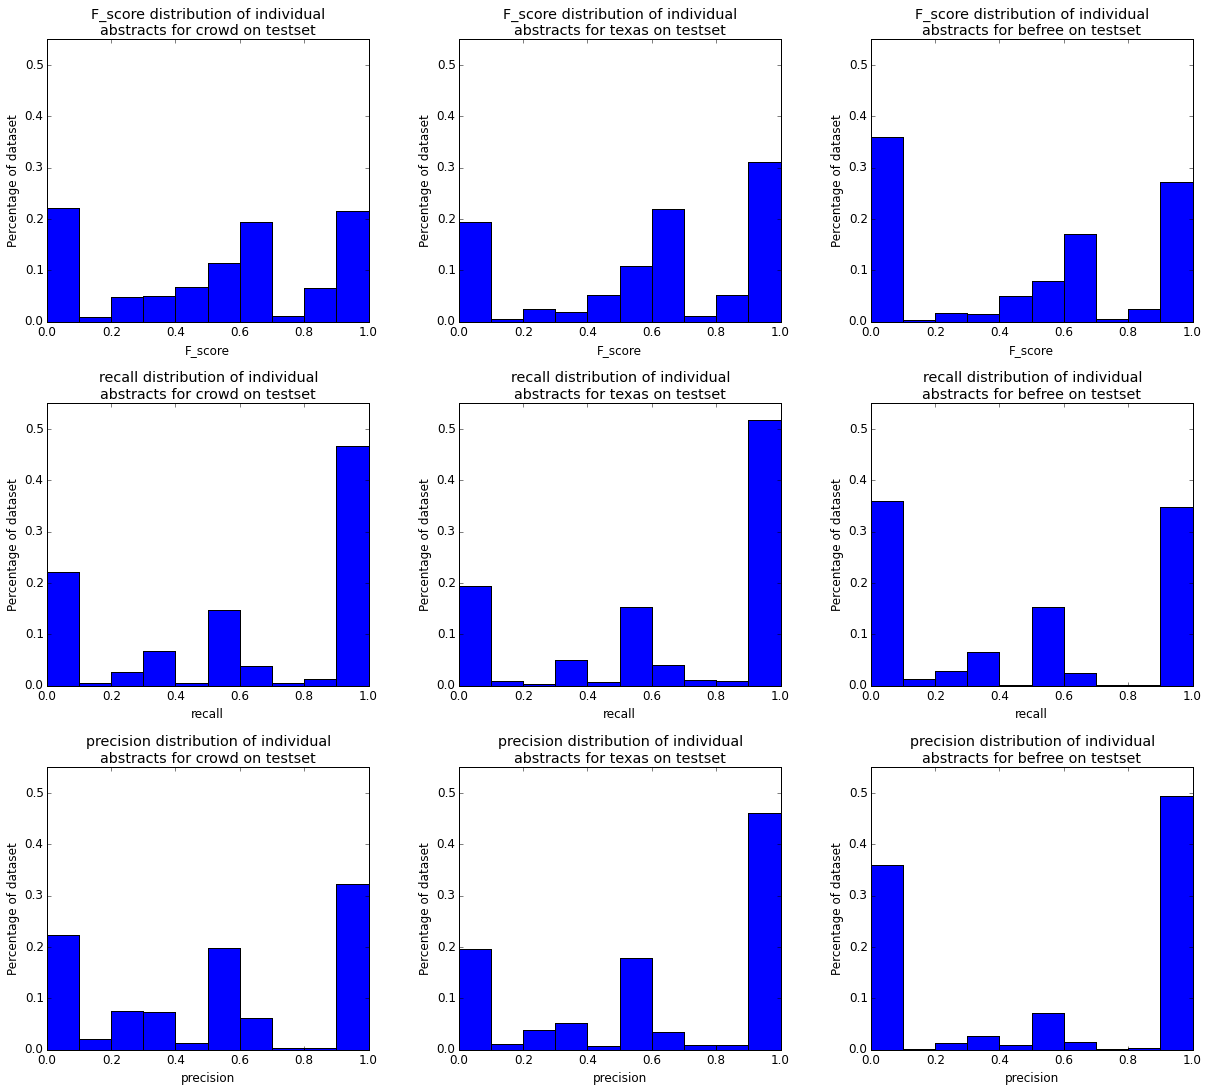

In [49]:
individual_perf_plot(ind_res)

Based on these plots, it seems that all three solutions shared a pattern of doing perfectly on some papers (F score = 1) and doing very poorly (F score = 0) on other papers. The two groups by far represent the largest parts of the distribution. Interestingly, we also see in all three solutions an increasing distribution as the F-score improves.

### Official MeSH terms for the top and worst performing abstracts for each method

Does the content of a paper determine whether the different techniques will perform better or worse?

In [50]:
# generate all the mesh terms for the different subgroups

res_mesh_terms = defaultdict(lambda: defaultdict(set))
for method, df in ind_res.items():
    for state, threshold in zip(["good", "bad"], [(0.9, 1.0), (0.0, 0.1)]):
        pmids = set(df.query("{} <= F_score <= {}".format(threshold[0], threshold[1]))["pmid"])
        temp = []
        for pmid in pmids:
            mesh_terms[pmid].mesh_terms["pmid"] = pmid
            temp.append(mesh_terms[pmid].mesh_terms)

        res_mesh_terms[method][state] = pd.concat(temp)

In [51]:
# print to file so that we can make word clouds

for method in ["crowd", "texas", "befree"]:
    for state in ["good", "bad"]:
        for major in ["all", "major"]:
            sub = res_mesh_terms[method][state]
            if major == "major":
                sub = sub.query("major_topic == True")
            
            # just the descriptors for now...
            terms = pd.DataFrame(sub["desc_name"].value_counts())
            fname = "temp/{}_{}_{}.txt".format(method, state, major)
            
            terms.to_csv(fname, sep = ":", index = True, header = False)

For acutal visualization purposes only the major MeSH terms for each paper was used to generate the word clouds, since the top concepts for all mesh terms are very similar (Man, human, etc).

---

### Individual abstract performance for the perfectly annotated subset

In [52]:
def individual_perf2(df, gold_std):
    res = defaultdict(list)
    for pmid, group in gold_std.groupby("pmid"):
        # for all papers where gold has at least one relation
        gold_sub = get_triples(group)
        
        predict_sub = get_triples(df.query("pmid == {}".format(pmid)))
        
        precision, recall, f1 = performance(gold_sub, predict_sub)
        
        res["pmid"].append(pmid)
        res["precision"].append(precision)
        res["recall"].append(recall)
        res["F_score"].append(f1)
        
    # for all papers where no gold relations but we made a prediction (all false positives)
    # if using F score, would get 0/0 for recall
    temp = defaultdict(list)
    for pmid in set(df["pmid"]) - set(gold_std["pmid"]):
        temp["pmid"].append(pmid)
        temp["false_pos"].append(len(df.query("pmid == {}".format(pmid))))
        
    return (pd.DataFrame(res), pd.DataFrame(temp))

In [53]:
ind_res_no_ner = {
    "crowd": individual_perf2(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold),
    "texas": individual_perf2(texas_no_ner, ut_good_gold),
    "befree": individual_perf2(befree_no_ner, befree_good_gold)
}

In [54]:
def individual_perf_plot2(dfs):
    """Plots the precision, recall, and F_score for
    the papers individually by solution.
    """
    N = len(dfs.keys())
    fig, ax = plt.subplots(3, N, figsize = (6 * N, 16))
    fig.tight_layout(pad = 5)
    
    for j, info in enumerate(dfs.items()):
        method, df = info
        df = df[0]
        for i, metric in enumerate(["F_score", "recall", "precision"]):
            hist, bins = np.histogram(df[metric])

            ax[i][j].bar(bins[:-1], hist.astype(np.float32) / hist.sum(),
                     width = (bins[1] - bins[0]))

            ax[i][j].set_title("{} distribution of individual\nabstracts for {} on testset".format(
                metric, method))
            ax[i][j].set_xlabel(metric)
            ax[i][j].set_ylabel("Percentage of dataset")
            ax[i][j].set_ylim((0, 0.75))

In [55]:
for method, vals in ind_res_no_ner.items():
    _, fps = vals
    print(method)
    print("number of papers with false positives:", len(fps))
    print("total number of false positives:", fps["false_pos"].sum())
    print("---")

crowd
number of papers with false positives: 44
total number of false positives: 85
---
texas
number of papers with false positives: 48
total number of false positives: 75
---
befree
number of papers with false positives: 36
total number of false positives: 75
---


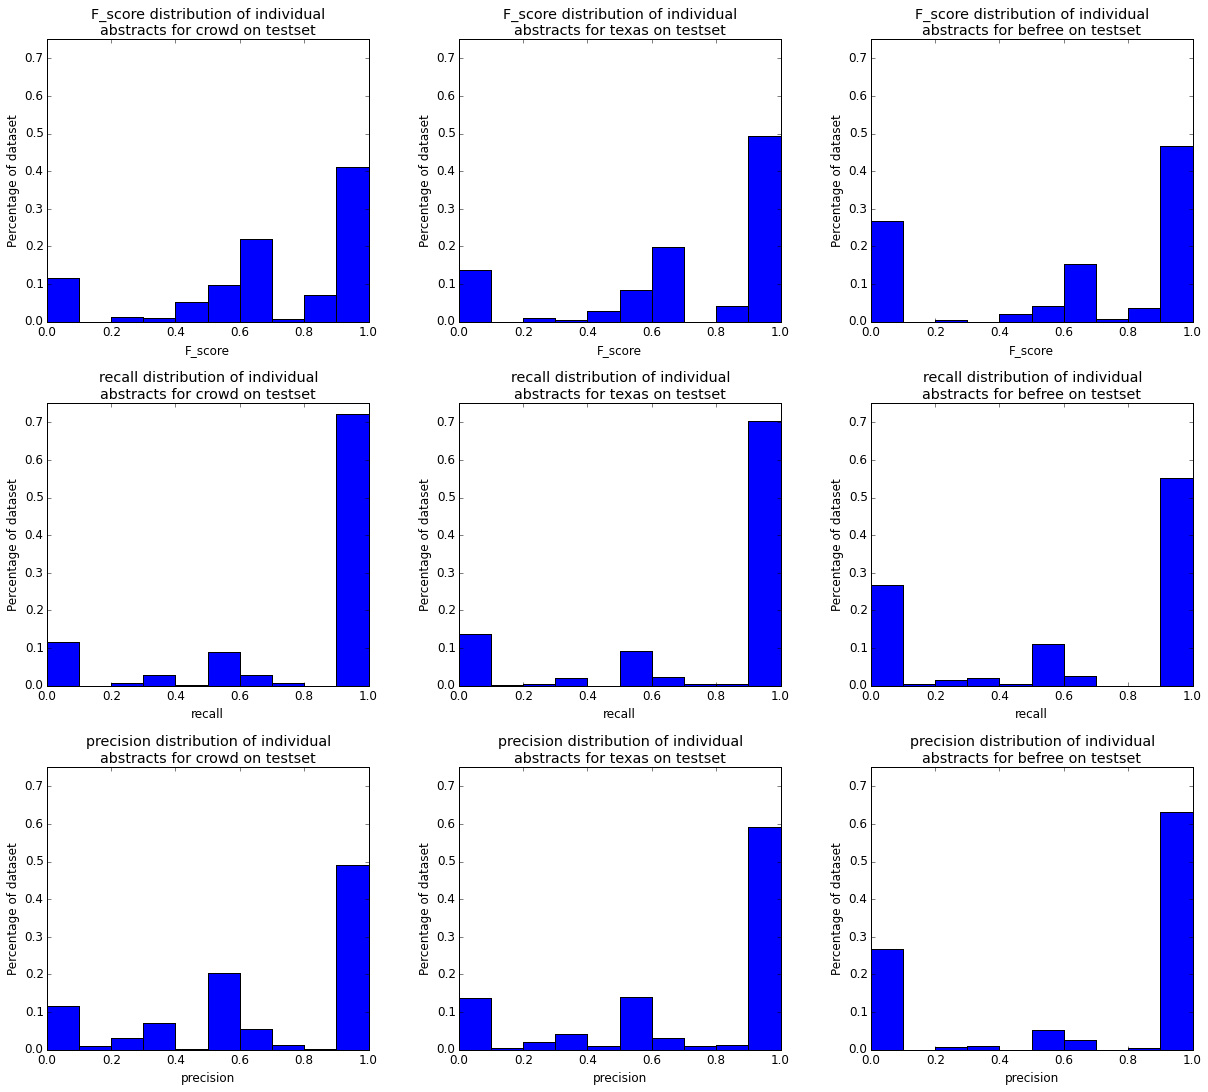

In [56]:
individual_perf_plot2(ind_res_no_ner)

---

### Venn diagram of relations

In [57]:
# format triples to make venn diagrams using:
# bioinformatics.lu/venn.php
# bioinfogp.cnb.csic.es/tools/venny
        
names = ["gold", "crowd", "utexas", "befree"]
data = [gold_triples, crowd_trip, ut_trip, befree_trip]
    
for fname, dataset in zip(names, data):
    print_to_file("{}.txt".format(fname), format_set(dataset))

### Gold, crowd, and texas only
<img src="../data/notebook/better_testset_cross_validation.png" style="width: 500px;">

### Gold, crowd, texas, and befree
<img src="../data/notebook/testset_all_cross_validation.png" style="width: 500px;">

---

### Percent relations in each subset with ids missing in gold standard

In [58]:
def missing_stats(triples, reference):
    df = make_df(triples)
    df = check_exists(df, reference)
    
    ans = dict()
    for col in ["chem", "dise"]:
        cname = "{}_exists".format(col)
        norm = df[cname].value_counts(normalize = True)
        res = norm.loc[False] if False in norm.keys() else 0
        ans[col] = res * 100
        
    ans["any"] = len(df.query("~chem_exists or ~dise_exists")) / len(df) * 100
    return ans

---

### Abstract vs sentence relations

In [59]:
def converter(pmid, poss_relations):
    return [Relation(pmid, rel[0], rel[1]) for rel in poss_relations]

def rel_origin(triple, paper):
    relation = Relation(paper.pmid, triple[1], triple[2], flat = False)

    rename = {
        "CID": "CID",
        "sentence_non_CID": "sent",
        "not_sentence_bound": "abs"
    }
    
    ans = []
    for key, val in paper.poss_relations.items():
        value = converter(paper.pmid, val)
        if relation in value:
            ans.append(rename[key])

    return ans

def triple_origin(triples, reference, return_res = False):
    lengths = []
    vals = []
    for trip in triples:
        pmid = trip[0]
        res = rel_origin(trip, reference[pmid])
        
        vals += res
        lengths.append(len(res))
        
    if return_res:
        return pd.Series(vals).value_counts(normalize = True) * 100    
        
    print("For this triple set of length {}".format(len(triples)))
    print("Origin group lengths:")
    print(pd.Series(lengths).value_counts())
    print()
    print("Origin counts:")
    print(pd.Series(vals).value_counts(normalize = True) * 100)

### Relation co-occurrence for each dataset separately

For each technique where did the predicted relations come from?

,sent,abs,CID
gold,54.562384,29.888268,15.549348
crowd,52.848885,31.131296,16.019818
texas,64.343164,21.000894,14.655943


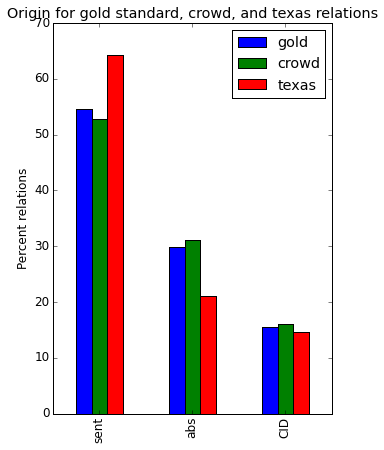

In [60]:
a = triple_origin(gold_triples, eval_gold, return_res = True)
b = triple_origin(crowd_trip, crowd_full, return_res = True)
c = triple_origin(ut_trip, ut_full, return_res = True)

rel_origins = pd.DataFrame([a, b, c], index = ["gold", "crowd", "texas"])

ax = rel_origins.T.plot(kind = "bar", figsize = (5, 7),
                    title = "Origin for gold standard, crowd, and texas relations")
ax.set_ylabel("Percent relations")
rel_origins

Seems like the crowd's answer response distribution is much closer to that of the gold's. The UTexas solution seems to prefer sentence-bound relations.

---

### Make one comprehensive dataframe for easier analysis

In [61]:
def new_check_exists(df, reference, ref_name):
    triple = ["pmid", "chemical_id", "disease_id"]
    for col in ["chemical", "disease"]:
        col_name = "{0}_in_{1}".format(col[:4], ref_name)
        
        df.loc[:, col_name] = df[triple].apply(
            lambda row: has_concept(reference[int(row["pmid"])], row["{}_id".format(col)]), axis = 1)
        
    return df

In [62]:
def single_triple_origin(pmid, chemical_id, disease_id, reference):
    triple = (pmid, chemical_id, disease_id)
    
    res = rel_origin(triple, reference[pmid])
    return "|".join(sorted(res))

In [63]:
def num_times_cooccur(pmid, chemical_id, disease_id, rel_origin, reference):
    """Given a relation triple and a reference Paper object,
    determines how many times the relation cooccurs (a sentence
    if CID or sentence, and 1 otherwise (abstract)).
    """
    if not rel_origin:
        # was not found using this solution
        return np.nan
    
    if rel_origin == "abs":
        return 1
    
    paper = reference[pmid]
    
    rel = Relation(pmid, chemical_id, disease_id, flat = False)
        
    ans = 0
    for sentence in paper.sentences:
        all_rels = sentence.poss_relations[rel_origin == "CID"]
        all_rels = [Relation(pmid, chem_set, dise_set) for chem_set, dise_set in all_rels]
        ans += int(rel in all_rels)
        
    return ans

In [64]:
# creating one comprehensive dataframe for easy result aggregation and querying

all_trips = gold_triples | crowd_trip | ut_trip
all_df = make_df(all_trips)

triple = ["pmid", "chemical_id", "disease_id"]

# which triple was found by which solution?
for name, reference in zip(["gold", "crowd", "texas"], [gold_triples, crowd_trip, ut_trip]):
    all_df.loc[:, "in_{}".format(name)] = all_df.loc[:, triple].apply(
        lambda row: (row["pmid"], row["chemical_id"], row["disease_id"]) in reference,
        axis = 1
    )
    
# were the concepts present in each dataset's concepts?
for name, reference in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):
    all_df = new_check_exists(all_df, reference, name)

# was the relation sentence bound or abstract level?
for name, reference in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):
    colname = "rel_orig_{}".format(name)
    
    all_df.loc[:, colname] = all_df.loc[:, triple].apply(
        lambda row: single_triple_origin(row["pmid"], row["chemical_id"], row["disease_id"], reference),
        axis = 1
    )
    
# how many times did the two concepts cooccur within the paper?    
for name, reference in zip(["gold", "crowd", "texas"], [eval_gold, crowd_full, ut_full]):    
    colname = "cooccur_{}".format(name)
    rel_orig = "rel_orig_{}".format(name)
    
    all_df.loc[:, colname] = all_df.loc[:, triple + [rel_orig]].apply(
        lambda row: num_times_cooccur(row["pmid"], row["chemical_id"], row["disease_id"],
                                     row[rel_orig], reference),
        axis = 1
    )

In [65]:
all_df.head()

,pmid,chemical_id,disease_id,in_gold,in_crowd,in_texas,chem_in_gold,dise_in_gold,chem_in_crowd,dise_in_crowd,chem_in_texas,dise_in_texas,rel_orig_gold,rel_orig_crowd,rel_orig_texas,cooccur_gold,cooccur_crowd,cooccur_texas
0,11425091,MESH:D003042,MESH:D007235,True,False,False,True,True,True,False,True,False,sent,,,3,NaN,NaN
1,8511251,MESH:D003042,MESH:D007511,False,True,False,True,True,True,True,True,True,abs,abs,abs,1,1,1
2,19184102,MESH:D014635,MESH:D009765,True,True,True,True,True,True,True,True,True,sent,sent,sent,2,2,2
3,23892921,MESH:D003907,MESH:D001855,True,False,False,True,True,True,False,True,True,abs,,abs,1,NaN,1
4,3711722,MESH:D003035,MESH:D009202,True,False,True,True,True,True,True,True,True,sent,sent,sent,1,1,1


---

### How many of the sentence and abstract relations did each method find? What was the precision?

In [66]:
def found_stats():
    recall = dict()
    precision = dict()
    for method in ["crowd", "texas"]:
        rec_temp = dict()
        pre_temp = dict()
        for rel_type in ["CID", "sent", "abs"]:
            sub = all_df.query("in_gold and rel_orig_gold == '{}'".format(rel_type))
            total = len(sub)
            found = len(sub.query("in_{}".format(method)))
            
            guesses = all_df.query("in_{0} and rel_orig_{0} == '{1}'".format(method, rel_type))
            guesses = len(guesses)
            
            rec_temp[rel_type] = found / total * 100
            pre_temp[rel_type] = found / guesses * 100
            
        recall[method] = rec_temp
        precision[method] = pre_temp
        
    return (pd.DataFrame(recall), pd.DataFrame(precision))

In [67]:
recall, precision = found_stats()

,crowd,texas
CID,87.116564,83.435583
abs,36.392405,35.443038
sent,54.058722,63.903282


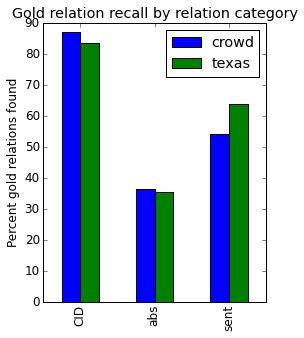

In [68]:
ax = recall.plot(kind = "bar", figsize = (4, 5),
        title = "Gold relation recall by relation category")

ax.set_ylabel("Percent gold relations found")

recall

,crowd,texas
CID,73.195876,82.926829
abs,30.503979,47.659574
sent,48.906250,51.388889


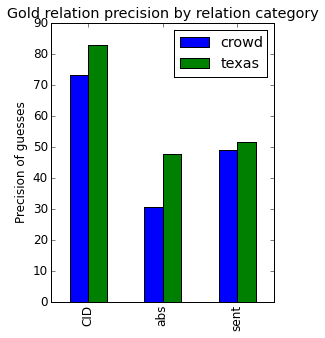

In [69]:
ax = precision.plot(kind = "bar", figsize = (4, 5),
        title = "Gold relation precision by relation category")

ax.set_ylabel("Precision of guesses")

precision

The two solutions found similar fractions of CID and abstract relations. The Texas solution found more sentence relations, but their predictions also contained more sentence-level relations overall. This is bad.. We are showing in different ways why the automated solution was better than our crowd..

### Of the relations which neither technique got, why did we not get them?

,any,chem,dise
crowd,63.888889,19.097222,49.652778
texas,56.944444,17.013889,42.708333


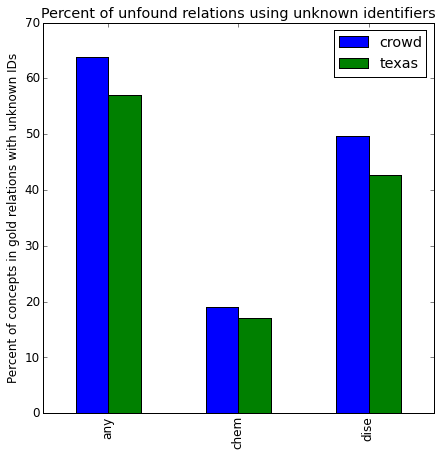

In [70]:
unfound = gold_triples - crowd_trip - ut_trip

crowd_miss = missing_stats(unfound, crowd_full)
ut_miss = missing_stats(unfound, ut_full)

missing = pd.DataFrame([crowd_miss, ut_miss], index = ["crowd", "texas"])

ax = missing.T.plot(kind = "bar", figsize = (7, 7),
             title = "Percent of unfound relations using unknown identifiers")

ax.set_ylabel("Percent of concepts in gold relations with unknown IDs")
missing

So a vast majority of the missed gold relations were unfound mainly because they used an ID which did not appear anywhere in the NER output for that paper.

For the relations which were indexed, what was the scope of the relation?

,abs,sent
crowd,55.769231,44.230769
texas,60.483871,39.516129


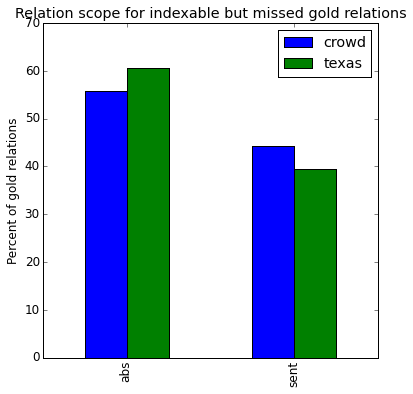

In [71]:
unfound = all_df.query("in_gold and ~in_crowd and ~in_texas")
crowd_miss = unfound.query("chem_in_crowd and dise_in_crowd")["rel_orig_gold"].value_counts(normalize = True) * 100
texas_miss = unfound.query("chem_in_texas and dise_in_texas")["rel_orig_gold"].value_counts(normalize = True) * 100

missed = pd.DataFrame([crowd_miss, texas_miss], index = ["crowd", "texas"])

ax = missed.T.plot(kind = "bar", figsize = (6, 6),
                title = "Relation scope for indexable but missed gold relations")

ax.set_ylabel("Percent of gold relations")
missed

For both solutions, at least half of the indexable, missed gold relations were abstract scoped, and therefore likely harder to determine correctly. Texas's solution seems to have a slight bias for the abstract scoped relations, but the different is probably not significant.

---

### For the relations which were false positives, what percentage were due to NER errors?

,any,chem,dise
crowd_only,34.435798,5.058366,30.350195
texas_only,24.800000,8.800000,16.533333
crowd_and_texas,9.090909,1.652893,7.438017


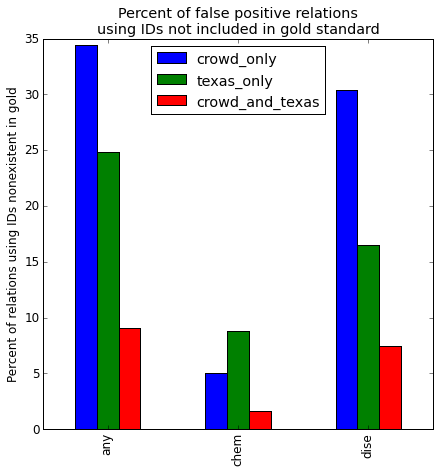

In [72]:
crowd_only = crowd_trip - gold_triples - ut_trip
texas_only = ut_trip - gold_triples - crowd_trip
crowd_ut = crowd_trip & ut_trip - gold_triples

cr_miss = missing_stats(crowd_only, eval_gold)
ut_miss = missing_stats(texas_only, eval_gold)
both_miss = missing_stats(crowd_ut, eval_gold)

missing = pd.DataFrame([cr_miss, ut_miss, both_miss], index = ["crowd_only", "texas_only", "crowd_and_texas"])

ax = missing.T.plot(kind = "bar", figsize = (7, 7),
                   title = "Percent of false positive relations\nusing IDs not included in gold standard")
ax.set_ylabel("Percent of relations using IDs nonexistent in gold")
missing

A significant number of the false positives for both solutions separately were a result of using MeSH IDs which did not occur in the gold standard. However, the false positives identified by both solutions have a significantly lower rate of NER error, suggesting that these were likely to be real relations which the gold does not include for some reason.

---

### For the gold relations which one solution got but the other missed, why did each solution miss the relations and what kind of relations are they?

,any,chem,dise
crowd_rels_missed_by_texas,20.645161,3.225806,17.419355
texas_rels_missed_by_crowd,40.099010,14.851485,28.217822


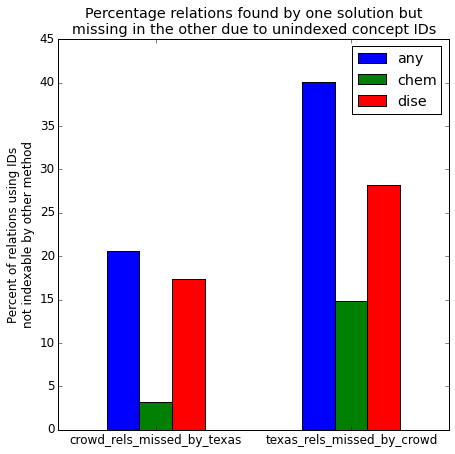

In [73]:
crowd_gold = all_df.query("in_gold and in_crowd and ~in_texas")
texas_gold = all_df.query("in_gold and in_texas and ~in_crowd")

crowd_gold = get_triples(crowd_gold)
texas_gold = get_triples(texas_gold)

# unindexable by texas, and by crowd
miss_by_ut = missing_stats(crowd_gold, ut_full)
miss_by_cr = missing_stats(texas_gold, crowd_full)

missing = pd.DataFrame([miss_by_ut, miss_by_cr],
                       index = ["crowd_rels_missed_by_texas", "texas_rels_missed_by_crowd"])
ax = missing.plot(kind = "bar", figsize = (7, 7),
                 title = "Percentage relations found by one solution but\n"
                 "missing in the other due to unindexed concept IDs")
ax.set_ylabel("Percent of relations using IDs\nnot indexable by other method")
ax.set_xticklabels(missing.index, rotation = 0)
missing

Based on the graph above, we see that the relations which our crowd got but Texas didn't only contained a small subset where the relations contained IDs which were not indexed by Texas. In contrast, a lot of the relations (40%) that Texas got but the crowd didn't were because the IDs were never found, not because the crowd is bad at relation extraction.

---